In [1014]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams.update({"figure.dpi":130,"font.family":'serif' })

import reportlib as rl

In [1015]:
import importlib
importlib.reload(rl)
figPath = rl.figPath

In [1016]:
# Prepare different databases
db = pd.read_csv("../output/database.csv")
rl.get_timecol(db)

fiddb = pd.read_csv("../output/fiddb.csv")
rl.get_timecol(fiddb)

testStart = np.datetime64('2023-06-27 10:40:00')
testFinish = testStart + np.timedelta64(1,"h")

df.shape

(2550, 39)

In [1017]:

# Because query_time uses label (not mvlabel or move), if initial selection is OK, then you can
# join using db.insert(len(db.columns))
mask1 = rl.query_time(db, datemin=testStart,datemax=testFinish)
mask2 = rl.query_time(fiddb, datemin=testStart,datemax=testFinish)

# Creating masks
df = db[mask1].reset_index(drop=True)
fiddf = fiddb[mask2].reset_index(drop=True)

# Inserting pix2mm and sigpix2mm
if rl.aligned(df,'move',fiddf,'mvlabel'):
    df.insert(len(df.columns),"fid x0",fiddf['x0'])
    df.insert(len(df.columns),"fid y0",fiddf['y0'])
    df.insert(len(df.columns),"fid x1",fiddf['x1'])
    df.insert(len(df.columns),"fid y1",fiddf['y1'])
    df.insert(len(df.columns),"fid x2",fiddf['x2'])
    df.insert(len(df.columns),"fid y2",fiddf['y2'])
    df.insert(len(df.columns),"fid x3",fiddf['x3'])
    df.insert(len(df.columns),"fid y3",fiddf['y3'])
    df.insert(len(df.columns),"pix2mm",fiddf['pix2mm'])
    df.insert(len(df.columns),"sigpix2mm",fiddf['sigpix2mm'])
    del fiddf
else:
    print("Movelabels are not aligned - inspect your movelabels and try again")

# Find sessions for each arcsequence
sessions = rl.getSessions(df)

# Make an arcnum session column and add it to the df
sessionLabels = rl.makeSessionLabels(sessions)

# Add session labels to the df
df.insert(len(df.columns),'ArcSession',sessionLabels)

#Find centers for each arcsequence
xc2_arr, yc2_arr, R2_arr, xc2_pix_arr, yc2_pix_arr = rl.phi_centers(df,sessions)

# Store centers in df
df.insert(len(df.columns),'xc2 mm',xc2_arr)
df.insert(len(df.columns),'yc2 mm',yc2_arr)
df.insert(len(df.columns),'R2 mm',R2_arr)
df.insert(len(df.columns),'xc2 pix',xc2_pix_arr)
df.insert(len(df.columns),'yc2 pix',yc2_pix_arr)

# Calculate x and y positions in mm
x_mm = df['xpix']*df['pix2mm']
y_mm = df['ypix']*df['pix2mm']

# Insert x and y positions to df
df.insert(12,'x mm',x_mm)
df.insert(13,'y mm',y_mm)

# Insert mount config into df in string form
df.insert(len(df.columns),'Mount Configuration',rl.set_MountConfig_String(df))

# Compute alpha individually
alpha_arr, req_arr, obs_arr = rl.getAlphas(df, backlash=1.5)

# Insert alpha to df
df.insert(len(df.columns),'Alpha',alpha_arr)
df.insert(len(df.columns),'Requested Move',req_arr)
df.insert(len(df.columns),'Observed Move',obs_arr)

# Compute mean and std of alpha of each session
mean_alpha_session,std_alpha_session, mean_alpha, std_alpha= rl.getMeans(df)

# Insert alpha session mean and std to df
df.insert(len(df.columns),'Mean Alpha',mean_alpha_session)
df.insert(len(df.columns),'Std Alpha',std_alpha_session)

In [1018]:
np.unique(req_arr)

array([17.49, 18.99,   nan])

In [1019]:
MountConfigs = np.unique(df['Mount Configuration'])
MountConfigs = [MountConfigs[1],MountConfigs[0],MountConfigs[2]] # REORDER TO GET THE CONFIGS IN CHRONOLOGICAL ORDER
colors = ['red','blue','green']
legendloc=0
title = "Fiducial Drift of 50 Iterations with 3 mount configurations"
save=False

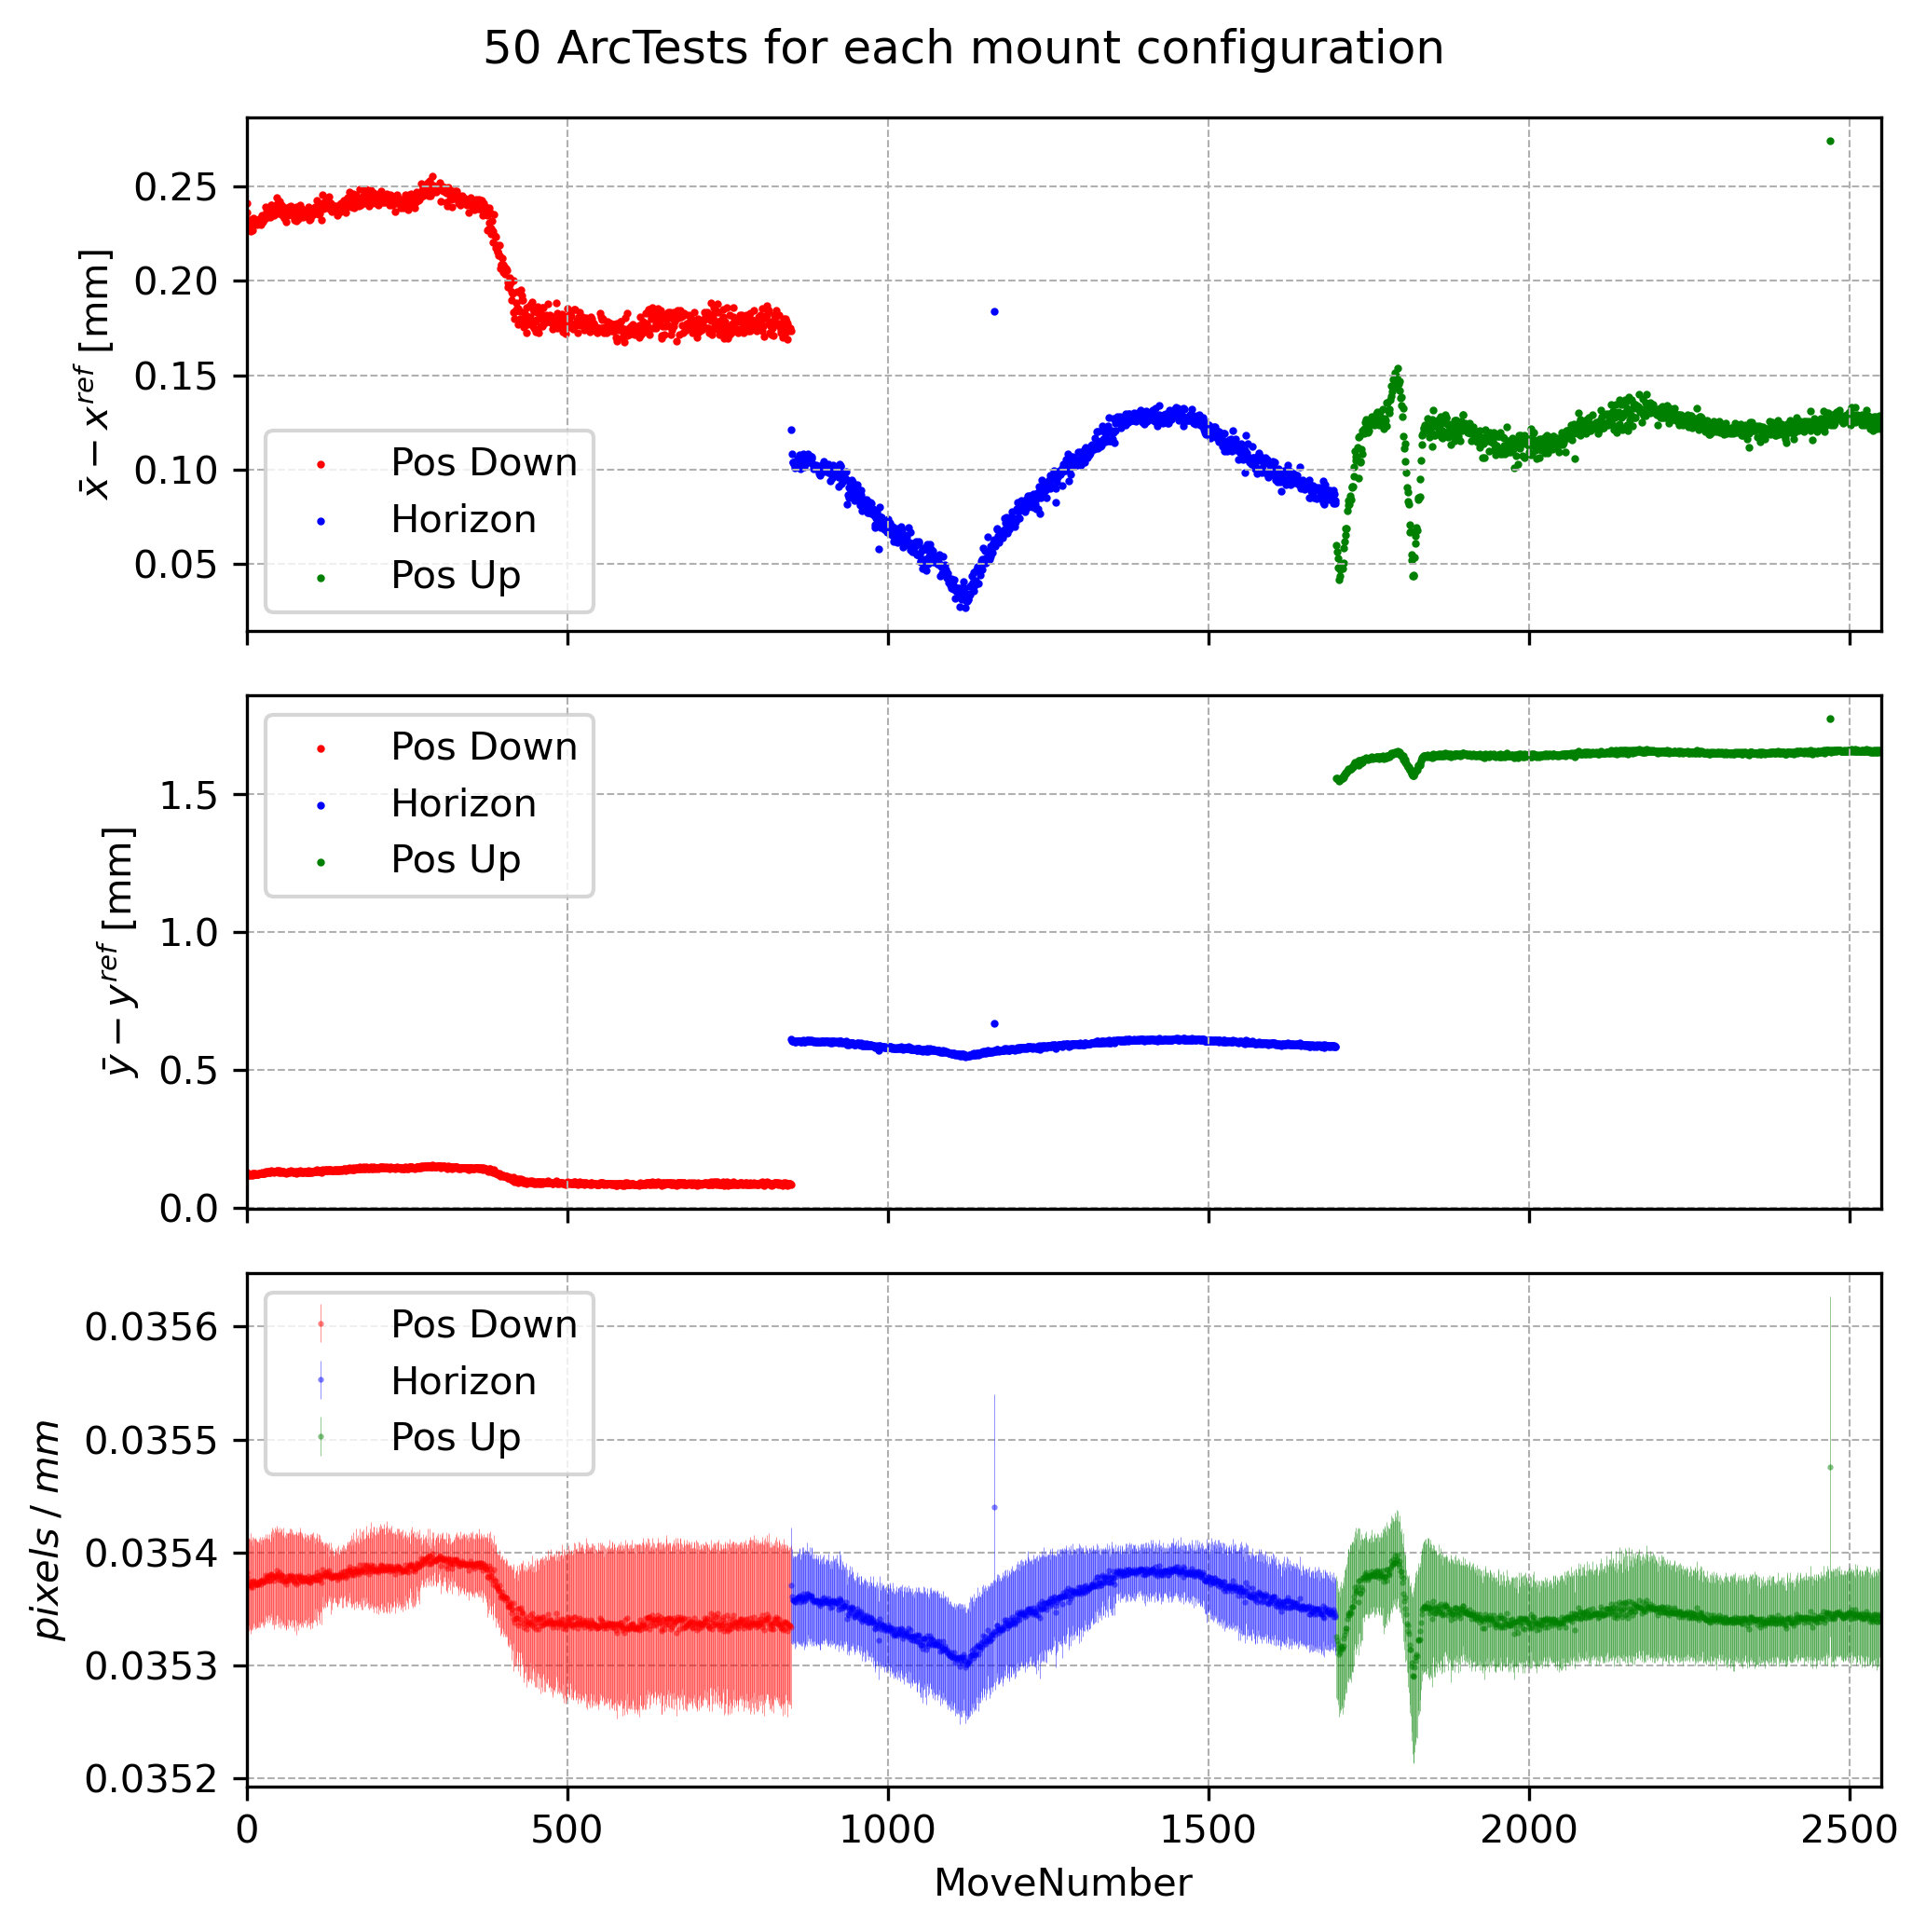

In [1048]:
fig,axs = plt.subplots(3,1,figsize=[7,7],dpi=300,sharex=True)

fig.suptitle(title)
ms=1
# First row - mean x fiducial position
init = 0
for j in range(len(MountConfigs)):
    axs[0].scatter(np.arange(init,
                             len(df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[17]])+init),
             df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[[17,19,21,23]]].mean(axis=1)\
                   *df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'] -39.6,
             color=colors[j],label=MountConfigs[j],s=ms)
    init+=len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])
axs[0].set_ylabel(r'$\bar{x} - x^{ref}$ [mm]')
axs[0].set_xlim(0,len(df))

# Second row - mean y fiducial position
init = 0
for j in range(len(MountConfigs)):
    axs[1].scatter(np.arange(init,len(df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[18]])+init),
             df[df['Mount Configuration']==MountConfigs[j]][df.columns.values[[18,20,22,24]]].mean(axis=1)\
                   *df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'] - 30.5,
             color=colors[j],label=MountConfigs[j],s=ms)
    init+=len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])
axs[1].set_ylabel(r'$\bar{y} - y^{ref}$ [mm]')
axs[1].set_xlim(0,len(df))

# Third row - pix/mm and sig pix/mm errorbar fig
init = 0
for j in range(len(MountConfigs)):
    axs[2].errorbar(np.arange(init,len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])+init),
             df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'],
             yerr=df[df['Mount Configuration']==MountConfigs[j]]['sigpix2mm'],color=colors[j],
             label=MountConfigs[j],capsize=0, fmt='.',elinewidth=.2,markersize=ms, alpha=0.5)
    init+=len(df[df['Mount Configuration']==MountConfigs[j]]['pix2mm'])
axs[2].set_ylabel(r'$pixels \;/\; mm$')
axs[2].set_xlabel('MoveNumber')
axs[2].set_xlim(0,len(df))
for i in range(3):
    axs[i].grid(linestyle='--',linewidth=0.5)
    axs[i].legend(loc=legendloc)
    
fig.tight_layout()
    
if save:
    plt.savefig(figPath+title+'.jpg',dpi=180)

plt.show()

# 2

In [1021]:
niter = 50

save= False
title = '50 ArcTests for each mount configuration'

Transitions = np.array(['Positioner Down',"Horizon","Positioner Up"])
Transition_colors = np.array(['red','blue','green'])
pointmarkers = ["v",'o','^']
markersize = 25

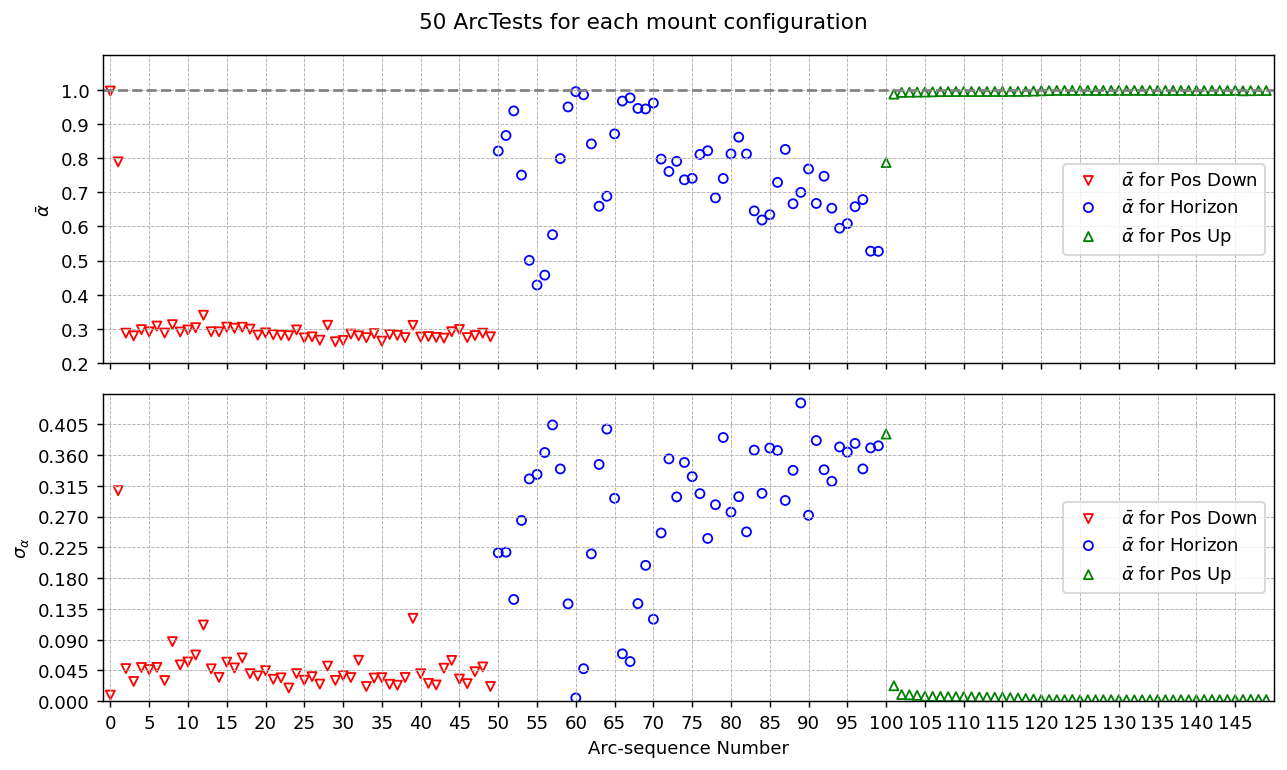

In [1022]:
fig,axs = plt.subplots(2,1,figsize=[10,6], dpi=130,sharex=True)

fig.suptitle(title)

ylimit = [0.2,1.1]
ystep = 0.1

axs[0].grid(linestyle='--',linewidth=0.5)
axs[0].hlines(1,-1,len(np.unique(df['ArcSession']))+1,linestyle='--',colors='grey')
axs[0].set_xlim(-1,max(df['ArcSession'])+1)
axs[0].set_ylabel(r"$\bar{\alpha}$")
for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Mean Alpha"], return_index=True)
    mean_alpha_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[0].scatter(res2,mean_alpha_arr,label=r"$\bar{\alpha}$ for "+MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')
axs[0].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[0].set_ylim(ylimit[0],ylimit[1])
axs[0].legend(loc=5)

ylimit = [0,0.45]
ystep = (ylimit[1]-ylimit[0])/10

axs[1].grid(linestyle='--',linewidth=0.5)
axs[1].set_xlim(-1,max(df['ArcSession'])+1)
axs[1].set_xlabel("Arc-sequence Number")
axs[1].set_ylabel(r"$\sigma_{\alpha}}$")
axs[1].set_xticks(np.arange(0,len(np.unique(df['ArcSession'])),step=5))

for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Std Alpha"], return_index=True)
    mean_std_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[1].scatter(res2,mean_std_arr,label=r"$\bar{\alpha}$ for "+MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')

axs[1].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[1].set_ylim(ylimit[0],ylimit[1])
axs[1].legend(loc=5)

fig.tight_layout()

if save:
    plt.savefig(figPath+title+'.jpg',dpi=180)


In [1023]:
niter = 50

save= False
title = '50 ArcTests for each mount configuration'

Transitions = np.array(['Positioner Down',"Horizon","Positioner Up"])
Transition_colors = np.array(['red','dodgerblue','green'])
pointmarkers = ["v",'o','^']
markersize = 25

In [1024]:
df['ArcSession'][np.argmin(df['Std Alpha'])]

125

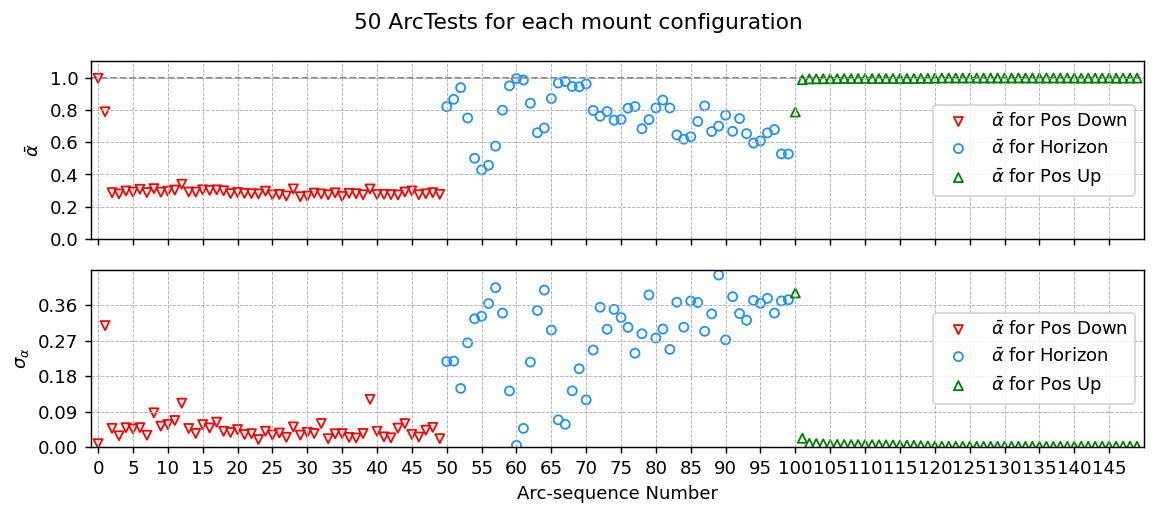

In [1025]:
fig,axs = plt.subplots(2,1,figsize=[9,4], dpi=130,sharex=True)

fig.suptitle(title)

ylimit = [0.0,1.1]
ystep = 0.2

axs[0].grid(linestyle='--',linewidth=0.5)
axs[0].axhline(1, linestyle='--', zorder=0, lw=1, c='grey')

axs[0].set_xlim(-1, max(df['ArcSession'])+1)
axs[0].set_ylabel(r"$\bar{\alpha}$")
for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Mean Alpha"], return_index=True)
    mean_alpha_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[0].scatter(res2,mean_alpha_arr,label=r"$\bar{\alpha}$ for "+MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')
    
axs[0].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[0].set_ylim(ylimit[0],ylimit[1])
axs[0].legend(loc=5)

# -==========================
ylimit = [0,0.45]
ystep = (ylimit[1]-ylimit[0])/5

axs[1].grid(linestyle='--',linewidth=0.5)
axs[1].set_xlim(-1,max(df['ArcSession'])+1)
axs[1].set_xlabel("Arc-sequence Number")
axs[1].set_ylabel(r"$\sigma_{\alpha}}$")
axs[1].set_xticks(np.arange(0,len(np.unique(df['ArcSession'])),step=5))

for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Std Alpha"], return_index=True)
    mean_std_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[1].scatter(res2,mean_std_arr,label=r"$\bar{\alpha}$ for "+MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')
    
#     print(np.argmin())

axs[1].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[1].set_ylim(ylimit[0],ylimit[1])
axs[1].legend(loc=5)

fig.tight_layout()

if save:
    plt.savefig(figPath+title+'.jpg',dpi=180)


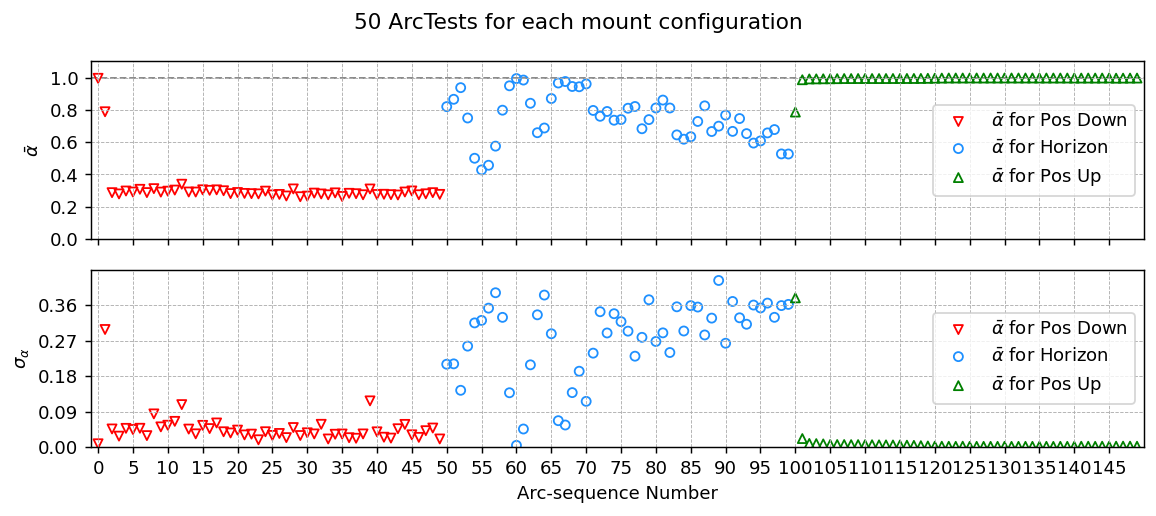

In [769]:
fig,axs = plt.subplots(2,1,figsize=[9,4], dpi=130,sharex=True)

fig.suptitle(title)

ylimit = [0.0,1.1]
ystep = 0.2

axs[0].grid(linestyle='--',linewidth=0.5)
axs[0].axhline(1, linestyle='--', zorder=0, lw=1, c='grey')

axs[0].set_xlim(-1, max(df['ArcSession'])+1)
axs[0].set_ylabel(r"$\bar{\alpha}$")
for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Mean Alpha"], return_index=True)
    mean_alpha_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[0].scatter(res2,mean_alpha_arr,label=r"$\bar{\alpha}$ for "+MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')
    
axs[0].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[0].set_ylim(ylimit[0],ylimit[1])
axs[0].legend(loc=5)

# -==========================
ylimit = [0,0.45]
ystep = (ylimit[1]-ylimit[0])/5

axs[1].grid(linestyle='--',linewidth=0.5)
axs[1].set_xlim(-1,max(df['ArcSession'])+1)
axs[1].set_xlabel("Arc-sequence Number")
axs[1].set_ylabel(r"$\sigma_{\alpha}}$")
axs[1].set_xticks(np.arange(0,len(np.unique(df['ArcSession'])),step=5))

for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Std Alpha"], return_index=True)
    mean_std_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[1].scatter(res2,mean_std_arr,label=r"$\bar{\alpha}$ for "+MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')
    
#     print(np.argmin())

axs[1].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[1].set_ylim(ylimit[0],ylimit[1])
axs[1].legend(loc=5)

fig.tight_layout()

if save:
    plt.savefig(figPath+title+'.jpg',dpi=180)


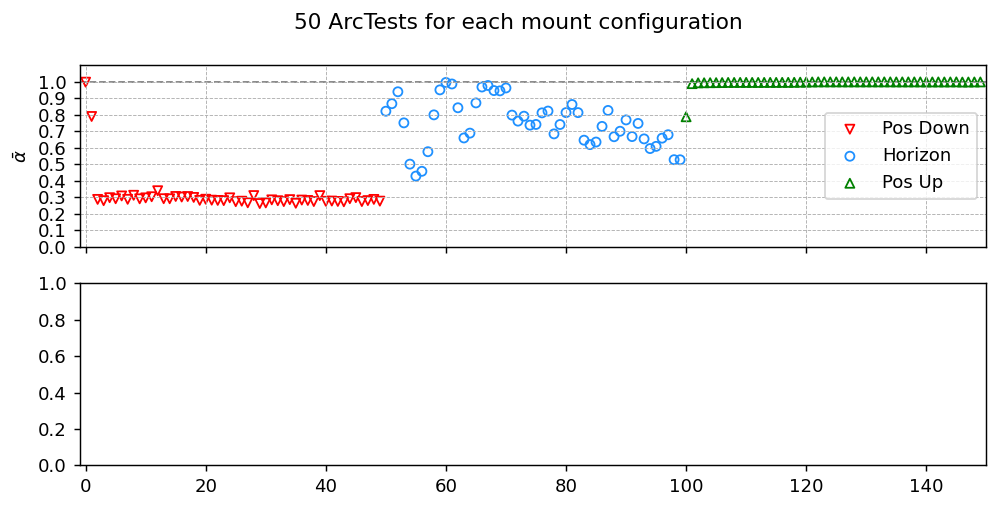

In [770]:
fig,axs = plt.subplots(2,1,figsize=[9,4], dpi=130,sharex=True)

fig.suptitle(title)

ylimit = [0.0,1.1]
ystep = 0.1

axs[0].grid(linestyle='--',linewidth=0.5)
axs[0].axhline(1, linestyle='--', zorder=0, lw=1, c='grey')

axs[0].set_xlim(-1, max(df['ArcSession'])+1)
axs[0].set_ylabel(r"$\bar{\alpha}$")
for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Mean Alpha"], return_index=True)
    mean_alpha_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    axs[0].scatter(res2,mean_alpha_arr, label=MountConfigs[j],marker=pointmarkers[j],
                   color=Transition_colors[j],s=markersize, facecolors='none')
    
axs[0].set_yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
axs[0].set_ylim(ylimit[0],ylimit[1])
axs[0].legend(loc=5)


Text(0.5, 0, 'Arc Sequence Number')

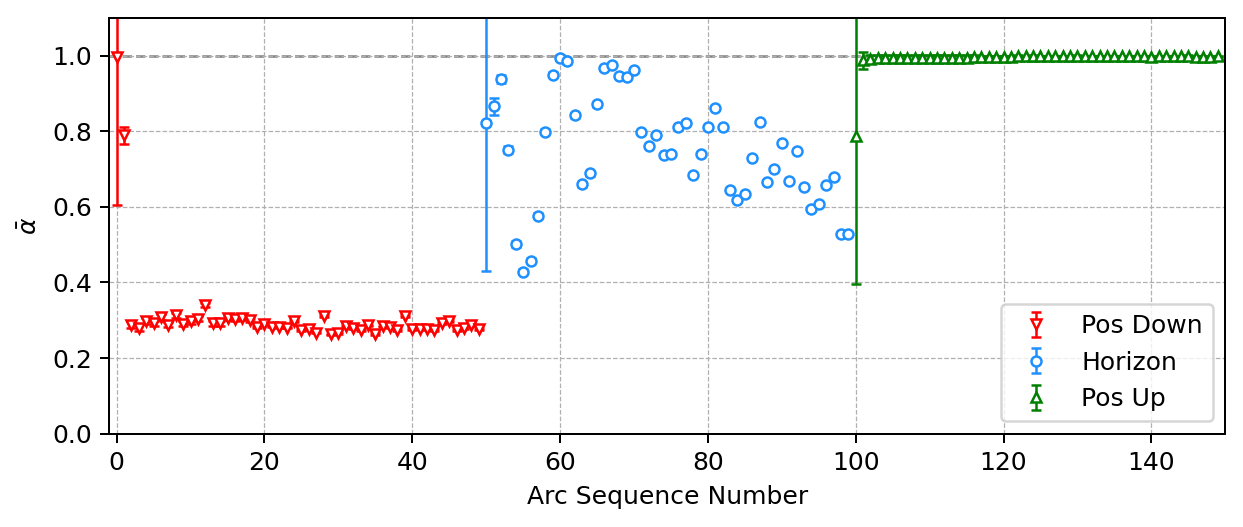

In [1026]:
# fig,axs = plt.subplots(2,1,figsize=[9,4], dpi=130,sharex=True)

# fig.suptitle(title)
plt.figure(figsize=(8,3), dpi=180)
ylimit = [0.0,1.1]
ystep = 0.2

plt.grid(linestyle='--',linewidth=0.5)
plt.axhline(1, linestyle='--', zorder=0, lw=1, c='grey')

plt.xlim(-1, max(df['ArcSession'])+1)
plt.ylabel(r"$\bar{\alpha}$")

for j in range(len(MountConfigs)):
    msk = df["Mount Configuration"]==MountConfigs[j]
    
    res, ind = np.unique(df[msk]["Mean Alpha"], return_index=True)
    mean_alpha_arr = res[np.argsort(ind)]
    
    res2, ind2 = np.unique(df[msk]["ArcSession"], return_index=True)
    
    plt.errorbar(res2, mean_alpha_arr, yerr=mean_std_arr, 
                 label=MountConfigs[j],
                 fmt=pointmarkers[j], ms=4, capsize=2., lw=1, 
                 markerfacecolor='w', 
                color=Transition_colors[j])
    
plt.yticks(np.arange(ylimit[0],ylimit[1],step=ystep))
plt.ylim(ylimit[0],ylimit[1])
plt.legend(loc='best')
plt.xlabel("Arc Sequence Number")


In [114]:
df[msk]

,label,session,mtang1,mtang2,move,posid,direction,speed,motor,angle,...,yc2 mm,R2 mm,xc2 pix,yc2 pix,Mount Configuration,Alpha,Requested Move,Observed Move,Mean Alpha,Std Alpha
1700,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-151605,4852,cw,cruise,phi,0.0,...,33.230054,3.090608,1896.960149,940.823547,Pos Up,NaN,NaN,NaN,0.789660,0.379754
1701,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-151613,4852,cw,cruise,phi,15.0,...,33.230054,3.090608,1896.960149,940.823547,Pos Up,0.983220,17.09,16.803222,0.789660,0.379754
1702,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-151622,4852,cw,cruise,phi,15.0,...,33.230054,3.090608,1896.960149,940.823547,Pos Up,0.971394,18.99,18.446765,0.789660,0.379754
1703,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-151631,4852,cw,cruise,phi,15.0,...,33.230054,3.090608,1896.960149,940.823547,Pos Up,0.985885,18.99,18.721964,0.789660,0.379754
1704,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-151640,4852,cw,cruise,phi,15.0,...,33.230054,3.090608,1896.960149,940.823547,Pos Up,0.992918,18.99,18.855508,0.789660,0.379754
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2545,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-172338,4852,ccw,cruise,phi,15.0,...,33.341172,3.077405,1898.456616,943.388240,Pos Up,0.999165,18.99,18.974137,1.000316,0.008608
2546,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-172348,4852,ccw,cruise,phi,15.0,...,33.341172,3.077405,1898.456616,943.388240,Pos Up,0.998180,18.99,18.955433,1.000316,0.008608
2547,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-172358,4852,ccw,cruise,phi,15.0,...,33.341172,3.077405,1898.456616,943.388240,Pos Up,0.998902,18.99,18.969150,1.000316,0.008608
2548,arc15_120,2023-06-27 10:48:41,-90.0,90.0,20230627-172408,4852,ccw,cruise,phi,15.0,...,33.341172,3.077405,1898.456616,943.388240,Pos Up,0.994657,18.99,18.888545,1.000316,0.008608


In [152]:
ymax = 450
colors = ['red','dodgerblue','green']
x_hist_range = [0.2,1.1]
save=False
label = 'Histograms for 50 Iterations'
kwargs = dict(histtype='stepfilled', alpha=0.25, bins=40, range=(x_hist_range[0],x_hist_range[1])
             )
np.unique(df['Mount Configuration'])
mount_conf = [ 'Pos Down','Horizon', 'Pos Up']

In [592]:
[f"{i:>8s}" for i in mount_conf]

['Pos Down', ' Horizon', '  Pos Up']

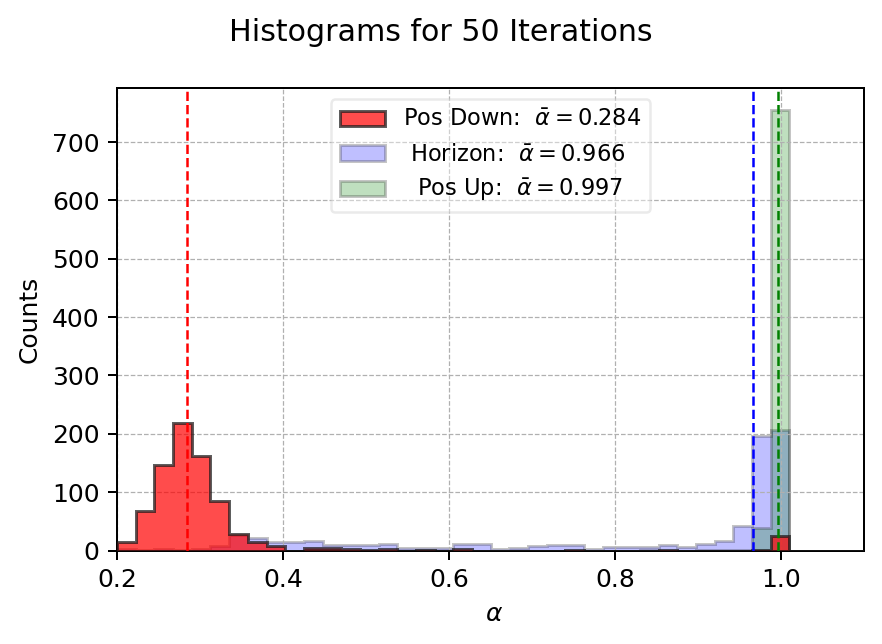

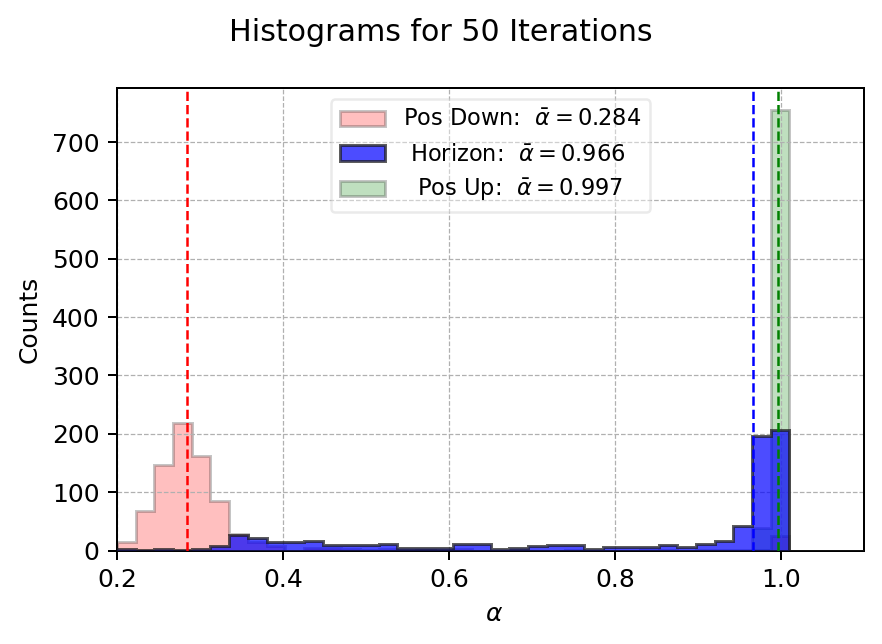

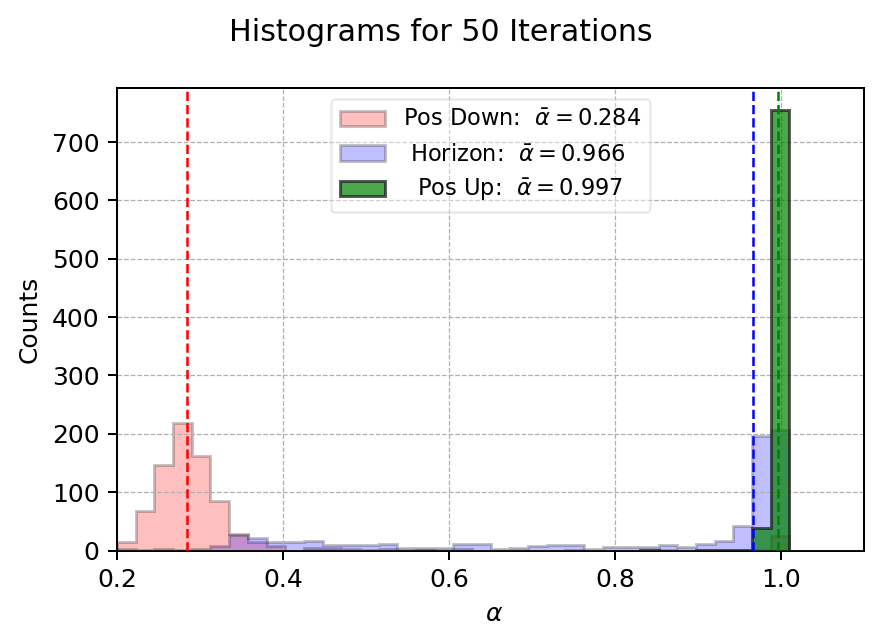

In [772]:
# Highlights
for ii in range(3):
    fig,ax = plt.subplots(figsize=[5,3.6], dpi=180)

    fig.suptitle(label, fontsize=12)
    ax.grid(linestyle='--',linewidth=0.5)

    for i, label_config in enumerate(mount_conf):
        if ii==i:
            kwargs.update({"alpha":0.7, "zorder":10} )
        else:
            kwargs.update({"alpha":0.25, "zorder":0})

        med_val = np.nanmedian(df[df['Mount Configuration']==label_config]["Alpha"])

        ax.hist(df[df['Mount Configuration']==label_config]['Alpha'],
                color=colors[i], edgecolor='k',  
                linewidth=1.2,
                label=f"{label_config:>8s}:  "+r'${\bar{\alpha}} = $'+f'{med_val:<.3f}', 
                **kwargs) #, zorder=10-2*i)

        ax.axvline(med_val, lw=1, 
                  linestyle='--',color=colors[i], zorder=15)

    legend = ax.legend(loc='best',framealpha=0.4, fontsize=9)

    ax.set_xlim(x_hist_range[0],x_hist_range[1])
    ax.set_xlabel(r' $\alpha$')
    ax.set_ylabel('Counts')

    fig.tight_layout()

    if save:
        plt.savefig(figPath+str(label)+'.jpg',dpi=180)

    plt.show()

In [246]:
st  = "eq"
st.startswith('eqqq')

False

In [250]:
df.columns
df['ArcSession'].unique()

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149])

In [981]:
grp = df.groupby('ArcSession')
grp.count()['Alpha'].unique()

def get_circle(c0,c1, r):
    th = np.linspace(0,2*np.pi, )
    return r*np.cos(th)+c0, r*np.sin(th)+c1


In [875]:
df['Mount Configuration'][amsk].iloc[0]

'Pos Down'

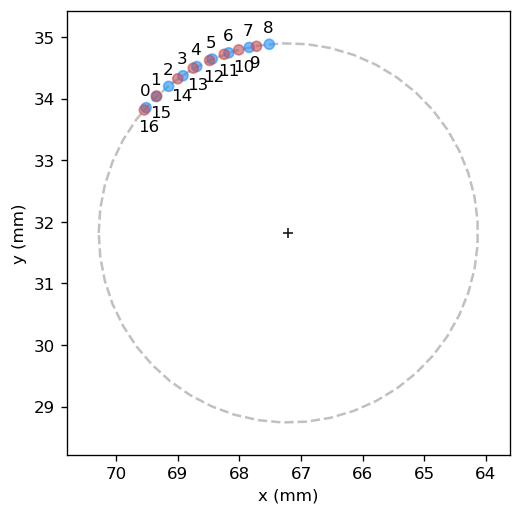

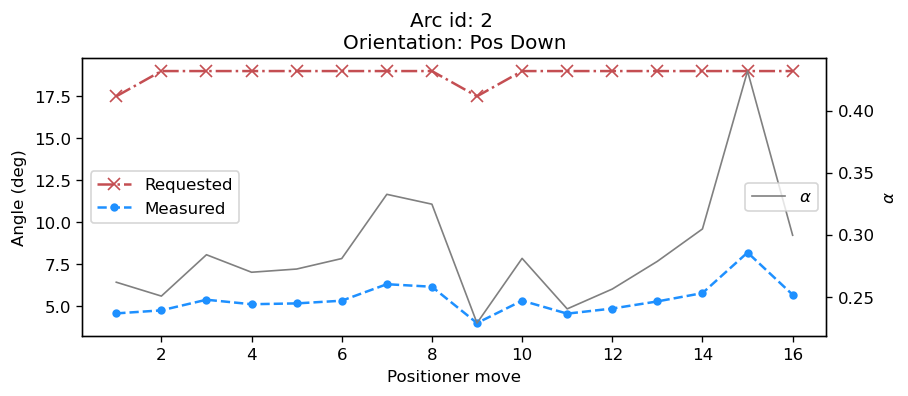

In [1027]:
iarc_session=2
amsk  = df.ArcSession==iarc_session
c = ['dodgerblue' if i =='cw' else 'r' for i in df[amsk]['direction']]

c0, c1, r0 = df[amsk][['xc2 mm','yc2 mm', 'R2 mm']].iloc[0,:]

rplt = 3.6
plt.xlim(c0+rplt,c0-rplt)
plt.ylim(c1-rplt,c1+rplt)
plt.xlabel("x (mm)")
plt.ylabel("y (mm)")
plt.scatter('x mm', 'y mm', 
            data=df[amsk], 
            c=c , alpha=0.6)

for i, (xi,yi) in enumerate(df[amsk][['x mm', 'y mm']].values):
    sign = [1 if i =='cw' else -1.7 for i in df[amsk]['direction']]
    plt.annotate(i, (xi+0.1,yi + sign[i]*.2), xycoords='data')
    
plt.plot(c0,c1, 'k+')
plt.plot(*get_circle(c0,c1, r0), '--', c='silver', zorder=0)
plt.gca().set_aspect('equal')
plt.show()


# plt.plot(df[amsk]['x mm'] - df[amsk]['x mm'].min(), '.')
# plt.plot(df[amsk]['y mm'] - df[amsk]['y mm'].min(), '+')
plt.figure(figsize=[8,3],)

plt.plot(df[amsk]['Requested Move'].values, 'rx-.',  ms=7, label='Requested' )
plt.plot(df[amsk]['Observed Move'].values, '.--', c='dodgerblue', ms=8, label='Measured')

plt.title(f"Arc id: {iarc_session} \nOrientation: {df['Mount Configuration'][amsk].iloc[0]}", fontsize=12)
plt.ylabel("Angle (deg)")
plt.xlabel("Positioner move")
plt.legend(loc='center left')
ax = plt.gca()
ax2 = ax.twinx()
ax2.plot(df[amsk]['Alpha'].values, lw=1, c='grey', zorder=0, label="$\\alpha$")
ax2.set_ylabel("$\\alpha$")
plt.legend(loc='center right')

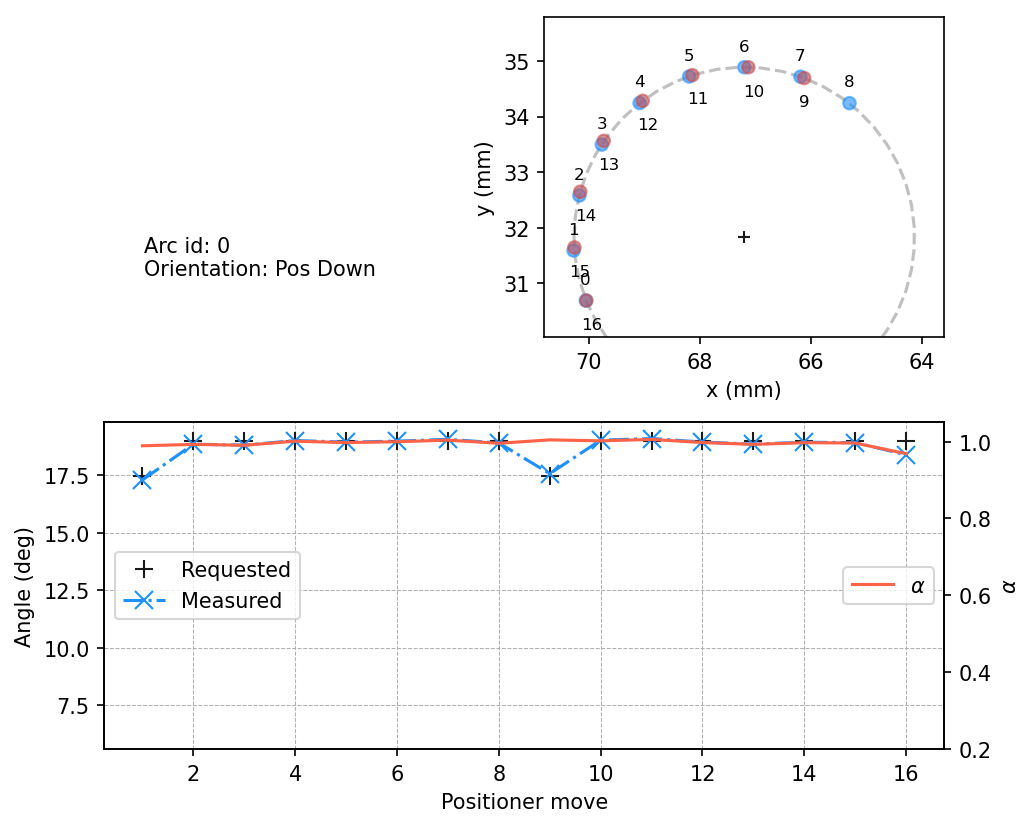

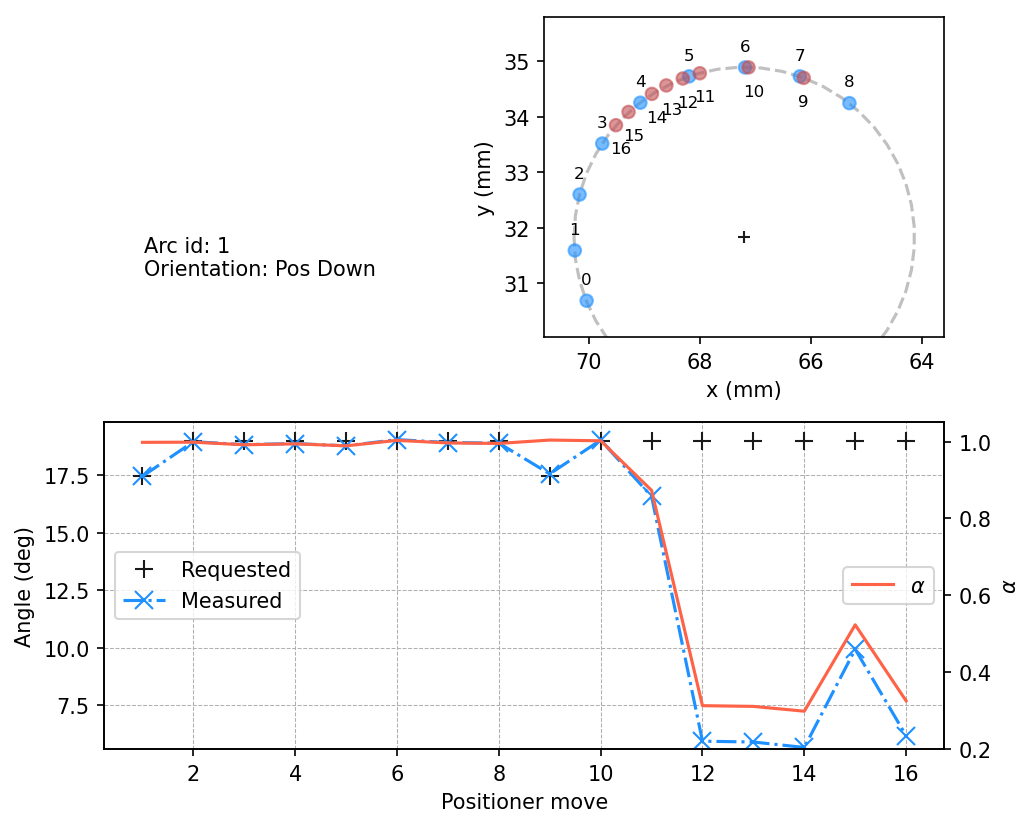

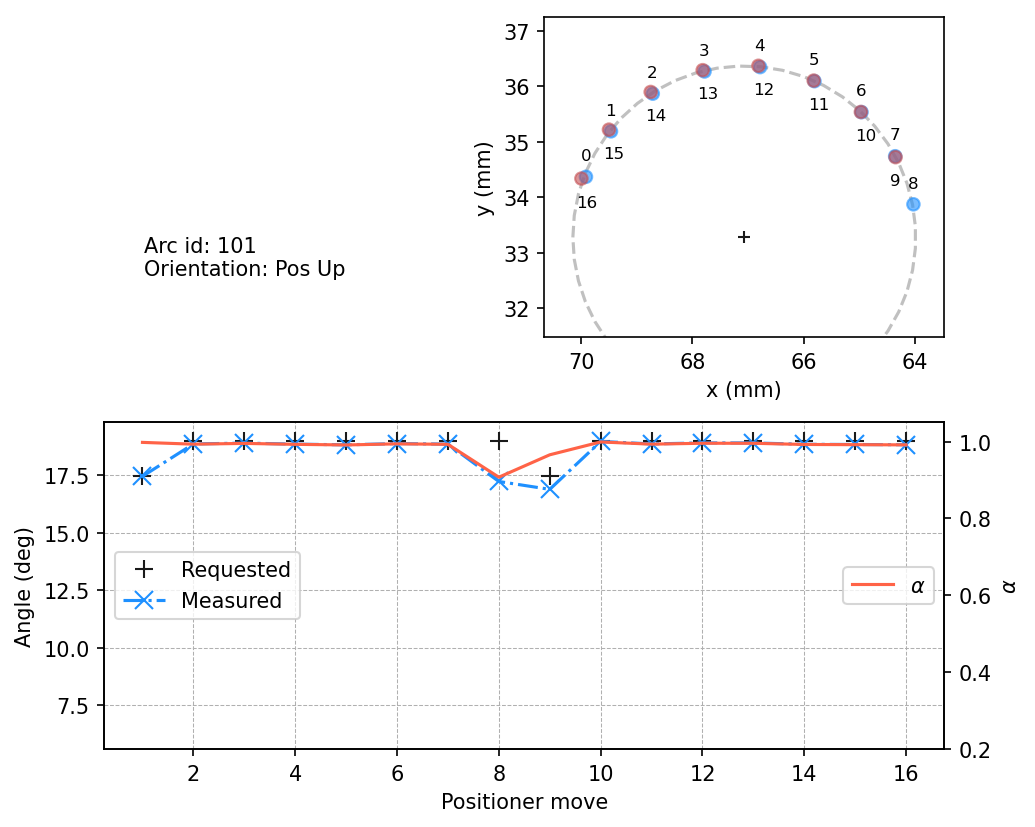

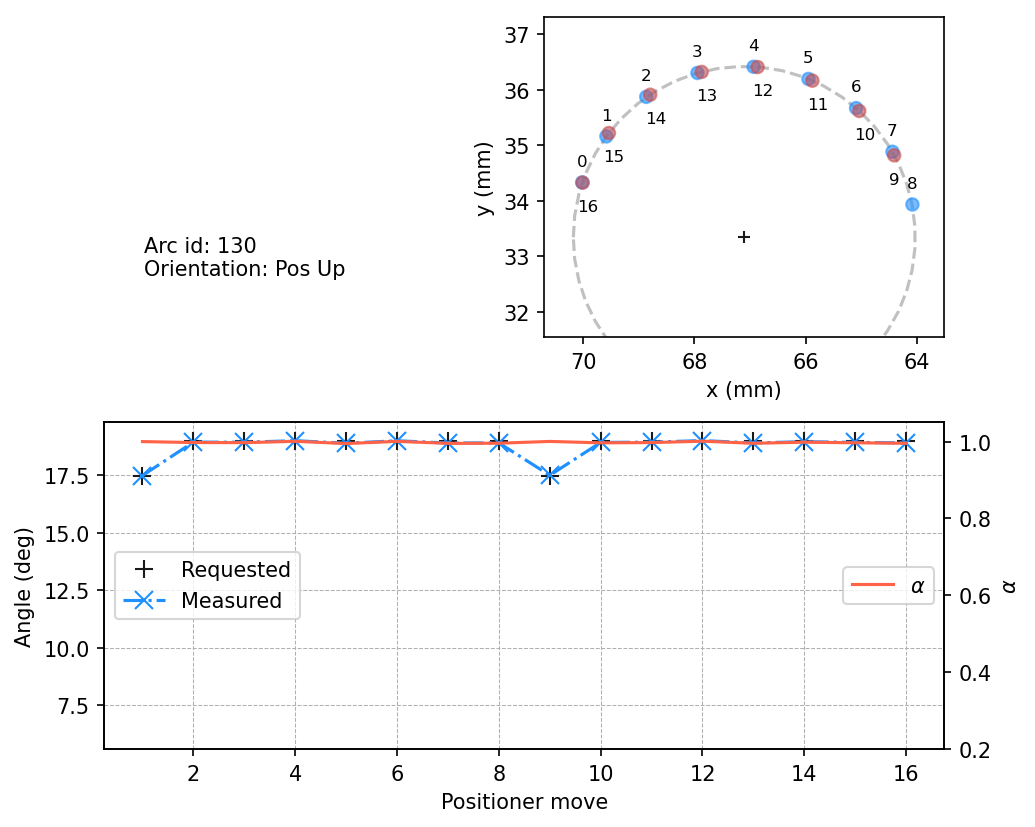

In [1041]:
for iarc_session in [0,1,101,130]:
    amsk  = df.ArcSession==iarc_session

    fig = plt.figure(figsize=(7,7), dpi=150 ) #, layout="constrained") 

    layout = """
                AB
                CC
                """
    ax = fig.subplot_mosaic(layout,     
        gridspec_kw={
            "bottom": 0.25,
            "top": 0.95,
            "left": 0.1,
            "right": .9,
            "wspace": 0.1,
            "hspace": 0.25,
        },
    )

    axi = ax["B"]
    info = f"Arc id: {iarc_session} \nOrientation: {df['Mount Configuration'][amsk].iloc[0]}"

    c = ['dodgerblue' if i =='cw' else 'r' for i in df[amsk]['direction']]

    c0, c1, r0 = df[amsk][['xc2 mm','yc2 mm', 'R2 mm']].iloc[0,:]

    rplt = 3.6
    axi.set_xlim(c0+rplt,c0-rplt)
    axi.set_ylim(c1-rplt/2,c1+ 1.1*rplt)
    axi.set_xlabel("x (mm)")
    axi.set_ylabel("y (mm)")
    axi.scatter('x mm', 'y mm', 
                data=df[amsk], 
                c=c , alpha=0.6)

    for i, (xi,yi) in enumerate(df[amsk][['x mm', 'y mm']].values):
        sign = [1 if i =='cw' else -1.7 for i in df[amsk]['direction']]
        axi.annotate(i, (xi+0.1,yi + sign[i]*.3), xycoords='data', fontsize=8)

    axi.plot(c0,c1, 'k+')
    axi.plot(*get_circle(c0,c1, r0), '--', c='silver', zorder=0)
    axi.set_aspect('equal')


    axi = ax["C"]
    axi.plot(df[amsk]['Requested Move'].values, '+',  c='k',  ms=9, label='Requested' )
    axi.plot(df[amsk]['Observed Move'].values, 'x-.', c='dodgerblue', ms=9, label='Measured')
    axi.grid(lw=0.5, ls='--')
    axi.set_ylabel("Angle (deg)")
    axi.set_xlabel("Positioner move")
    axi.legend(loc='center left')
    axi.set_ylim(5.6,19.8)

    ax2 = axi.twinx()
    ax2.plot(df[amsk]['Alpha'].values, lw=1.5, ls='-', c='tomato', zorder=0, label="$\\alpha$")
    ax2.set_ylabel("$\\alpha$")
    ax2.legend(loc='center right')
    ax2.set_ylim(0.2,1.05)

    ax["A"].annotate(info, (0.1,0.2))
    ax["A"].axis('off')
    plt.show()

17         NaN
18    0.998168
19    0.998575
20    0.991832
21    0.994248
22    0.989077
23    1.003319
24    0.996572
25    0.995279
26    1.004115
27    1.002165
28    0.873245
29    0.312957
30    0.311080
31    0.298571
32    0.523327
33    0.325530
dtype: float64

In [758]:
plt.rcParams = plt.rcParamsDefault
df['Requested Move'].unique()
_req = df['Requested Move'].values
_req[np.isclose(df['Requested Move'].values, 17.39)] =17.5
np.unique(_req)

# np.sum(df['Requested Move'].values == 17.09)

array([17.5 , 18.99,   nan])

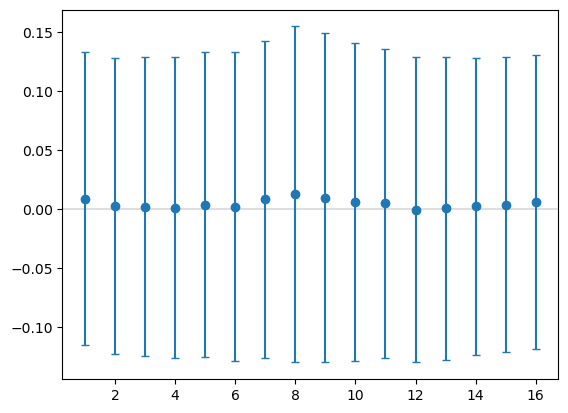

In [776]:
plt.errorbar( np.arange(17), (1- df["Alpha"][df["ArcSession"]==60])/57 * 3 *15, 
            yerr = df["fwhm"][df["ArcSession"]==60]*0.0353, fmt='o', capsize=3)
plt.axhline(0, zorder=0, lw=.2, c='k')

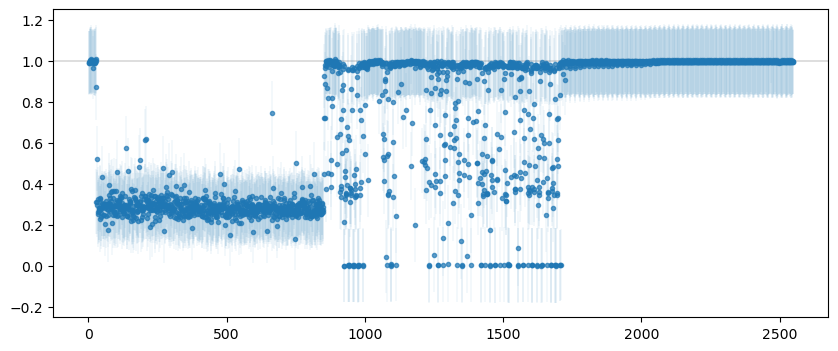

In [743]:
plt.figure(figsize=(10,4))
plt.errorbar( np.arange(len(df["Alpha"])),  (df["Alpha"]) , 
            yerr = df["fwhm"]*0.0353/ (3 *15/57), fmt='.', capsize=0, lw=.1, alpha=0.7)

plt.axhline(1, zorder=0, lw=.2, c='k')

In [352]:
df["R_measured"] = _r

Text(0.5, 0, 'R_measured')

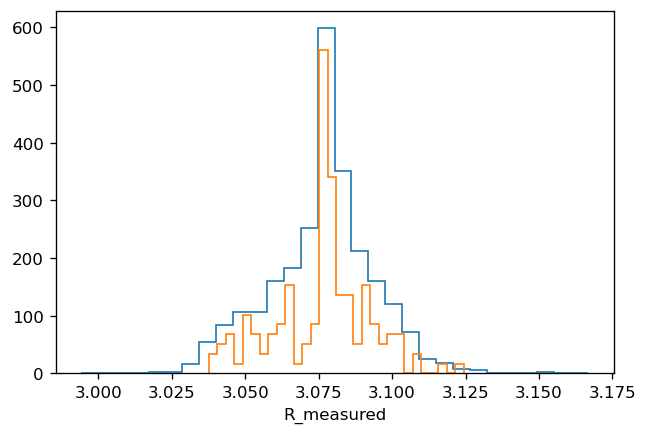

In [345]:
_msk = df["ArcSession"]==60 
_msk = np.ones(df.shape[0]).astype(bool)
_r = np.hypot(df[_msk]["x mm"].values - df[_msk]["xc2 mm"].values, 
              df[_msk]["y mm"].values - df[_msk]["yc2 mm"].values)
plt.hist(_r, histtype='step', bins=30);
plt.hist(df[_msk]["R2 mm"], histtype='step', bins=30, label='R2 (fit)')
plt.xlabel("R_measured")


axes.grid False
axes.grid.axis both
axes.grid.which major
axes3d.grid True
grid.alpha 1.0
grid.color .8
grid.linestyle -
grid.linewidth 1.0
keymap.grid ['g']
keymap.grid_minor ['G']
polaraxes.grid True


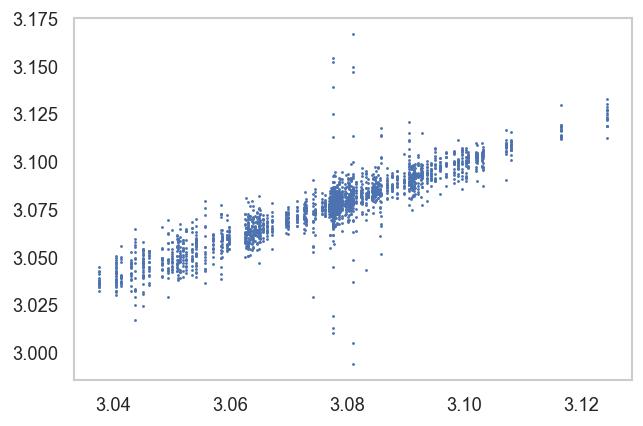

In [550]:
plt.scatter(df[_msk]["R2 mm"], _r, marker='.', s=2)
for i,v in plt.rcParams.items():
    if 'grid' in i:
        print(i,v)
plt.rcParams.update({"axes.grid":False})

In [297]:
# radius

df["R2 mm"]
df.columns

Index(['label', 'session', 'mtang1', 'mtang2', 'move', 'posid', 'direction',
       'speed', 'motor', 'angle', 'xpix', 'ypix', 'x mm', 'y mm', 'xytgt',
       'peaks', 'fwhm', 'fid x0', 'fid y0', 'fid x1', 'fid y1', 'fid x2',
       'fid y2', 'fid x3', 'fid y3', 'pix2mm', 'sigpix2mm', 'ArcSession',
       'xc2 mm', 'yc2 mm', 'R2 mm', 'xc2 pix', 'yc2 pix',
       'Mount Configuration', 'Alpha', 'Requested Move', 'Observed Move',
       'Mean Alpha', 'Std Alpha'],
      dtype='object')

In [422]:
import seaborn as sns
import scipy.stats as stats
sns.set_theme(style="whitegrid")

(2.985523474737012, 3.175356329596277)

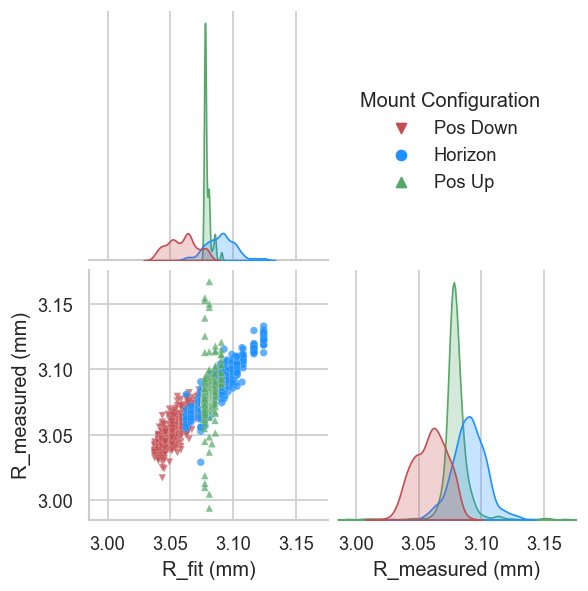

In [521]:

g = sns.pairplot(df[["R2 mm", "R_measured", "Mount Configuration"]], 
             corner=True,
             palette = dict(zip(df["Mount Configuration"].unique(), ["r", "dodgerblue", "g"])),
             hue="Mount Configuration", 
             markers=['v','o','^'],
             plot_kws={"s":20, "alpha":0.7, "edgecolor":"w", "linewidth":.1},
                )
# g.map_lower(sns.kdeplot, levels=1, color=".1")
# g.map_lower(sns.histplot) # levels=1, color=".1")

g.axes[1][0].set_xlabel("R_fit (mm)")
g.axes[1][0].set_ylabel("R_measured (mm)")
g.axes[1][1].set_xlabel("R_measured (mm)")

g.fig.get_children()[-1].set_bbox_to_anchor((0.5, 0.5, 0.2, 0.5))

newxlim = g.axes[1][0].get_ylim() 
g.axes[1][0].set_xlim(newxlim)
g.axes[1][1].set_xlim(newxlim)


In [491]:
grp = df[["R2 mm", "R_measured", "Mount Configuration"]].groupby("Mount Configuration")
grp.corr()

R2 mm  R_measured
Mount Configuration                                 
Horizon             R2 mm       1.000000    0.918430
                    R_measured  0.918430    1.000000
Pos Down            R2 mm       1.000000    0.880928
                    R_measured  0.880928    1.000000
Pos Up              R2 mm       1.000000    0.322481
                    R_measured  0.322481    1.000000

In [489]:
grp.agg([np.mean, np.median, lambda x: np.std(x, ddof=1)]).rename(columns={'<lambda_0>':'std'})

R2 mm                     R_measured            \
                         mean    median       std       mean    median   
Mount Configuration                                                      
Horizon              3.090083  3.090898  0.011904   3.089958  3.090145   
Pos Down             3.059237  3.059609  0.011480   3.059292  3.060047   
Pos Up               3.079212  3.077771  0.002828   3.079412  3.078274   

                               
                          std  
Mount Configuration            
Horizon              0.013066  
Pos Down             0.013045  
Pos Up               0.011210

In [525]:
grp2 = df[["pix2mm", "Mount Configuration"]].groupby("Mount Configuration")

grp2.agg([np.mean, np.median, lambda x: np.std(x, ddof=1)]).rename(columns={'<lambda_0>':'std'})

pix2mm                    
                         mean    median       std
Mount Configuration                              
Horizon              0.035353  0.035356  0.000022
Pos Down             0.035359  0.035346  0.000023
Pos Up               0.035346  0.035343  0.000014

In [529]:
df[['Alpha', 'ArcSession']].groupby("ArcSession").mean()

,Alpha
ArcSession,
0,0.998913
1,0.791558
2,0.288194
3,0.280348
4,0.298378
...,...
145,1.000768
146,0.999629
147,0.999938


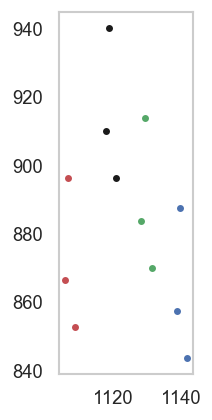

In [561]:
fcols = [#'ypix', 'x mm', 'y mm', 'xytgt',
        'peaks', 'fwhm', 
        'fid x0', 'fid y0', 'fid x1', 'fid y1', 'fid x2',
        'fid y2', 'fid x3', 'fid y3', 
        'pix2mm', 'sigpix2mm', 'ArcSession',
        'xc2 mm', 'yc2 mm', 
        'R2 mm', 'xc2 pix','yc2 pix',
        'Mount Configuration', 'Alpha', 
        'Requested Move', 'Observed Move']
gr3 = df[fcols].groupby(["Mount Configuration"])
# gr3.agg(np.mean)
plt.scatter(gr3.agg(np.mean)["fid x0"], gr3.agg(np.mean)["fid y0"], s=10,c='r')
plt.scatter(gr3.agg(np.mean)["fid x1"], gr3.agg(np.mean)["fid y1"], s=10,c='b')
plt.scatter(gr3.agg(np.mean)["fid x2"], gr3.agg(np.mean)["fid y2"], s=10,c='g')
plt.scatter(gr3.agg(np.mean)["fid x3"], gr3.agg(np.mean)["fid y3"], s=10,c='k')
plt.gca().set_aspect('equal')